# Sudoku Grid Detection

In [1]:
using Images
using ImageFiltering
using ImageBinarization
using OffsetArrays
using Plots
using FileIO
using Revise

In [2]:
Revise.includet("utilities/Contours.jl");
using .Contours
Revise.includet("utilities/Transforms.jl")
using .Transforms

## Load image

In [3]:
image_path = "images/nytimes_20210807.jpg";

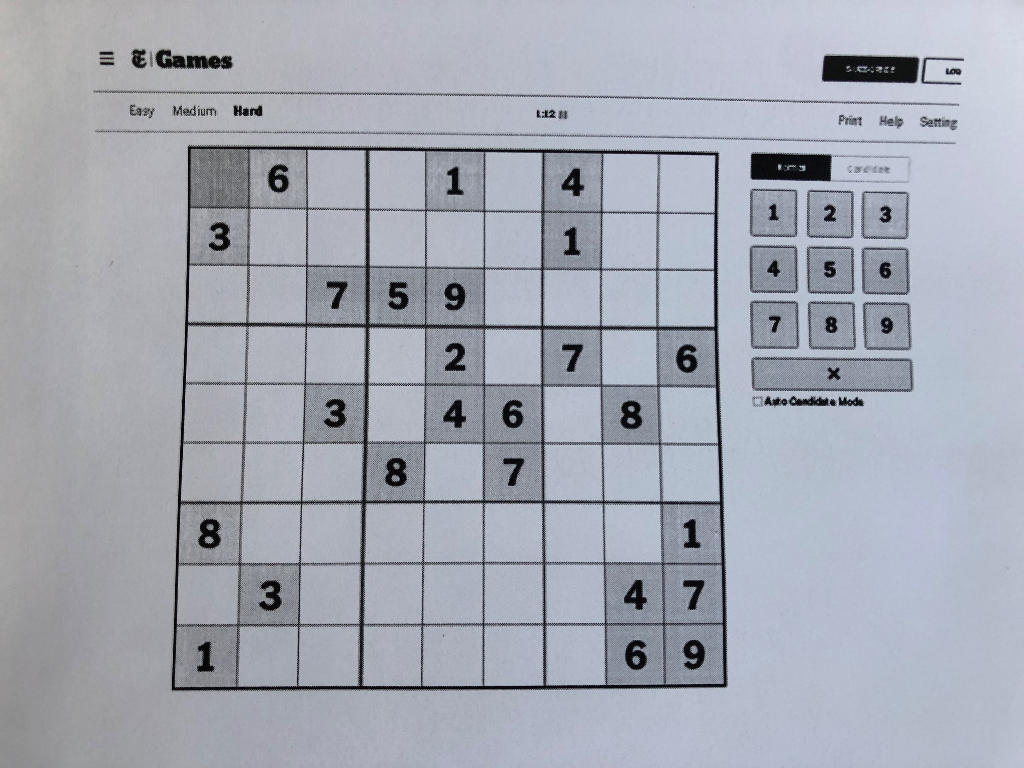

In [4]:
image_raw = load(image_path)
image = copy(image_raw)

max_size = 1024 
ratio = max_size/size(image, argmax(size(image)))
if ratio < 1
    image = imresize(image, ratio=ratio)
end

## Preprocess

In [5]:
window_size = 5;
σ = 1 # 0.3*((window_size - 1) * 0.5 - 1) + 0.8  # OpenCV default

1

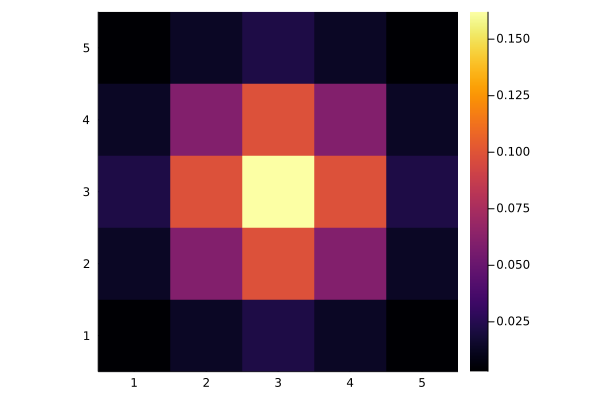

In [6]:
kernel = Kernel.gaussian((σ, σ), (window_size, window_size))
p = heatmap(1:window_size, 1:window_size, kernel, aspectratio=1, xlims=(0.5, 5.5))


In [7]:
kernel = Kernel.gaussian((σ, σ), (window_size, window_size))
gray = Gray.(image)
gray = imfilter(gray, kernel)
plot(hcat(Gray.(image), gray),  size = (800, 300), border=:none)

In [8]:
function invert_image(image)
    image_inv = Gray.(image)
    height, width = size(image)
    for i in 1:height
        for j in 1:width
            image_inv[i, j] = 1 - image_inv[i, j]
        end
    end
    return image_inv
end;

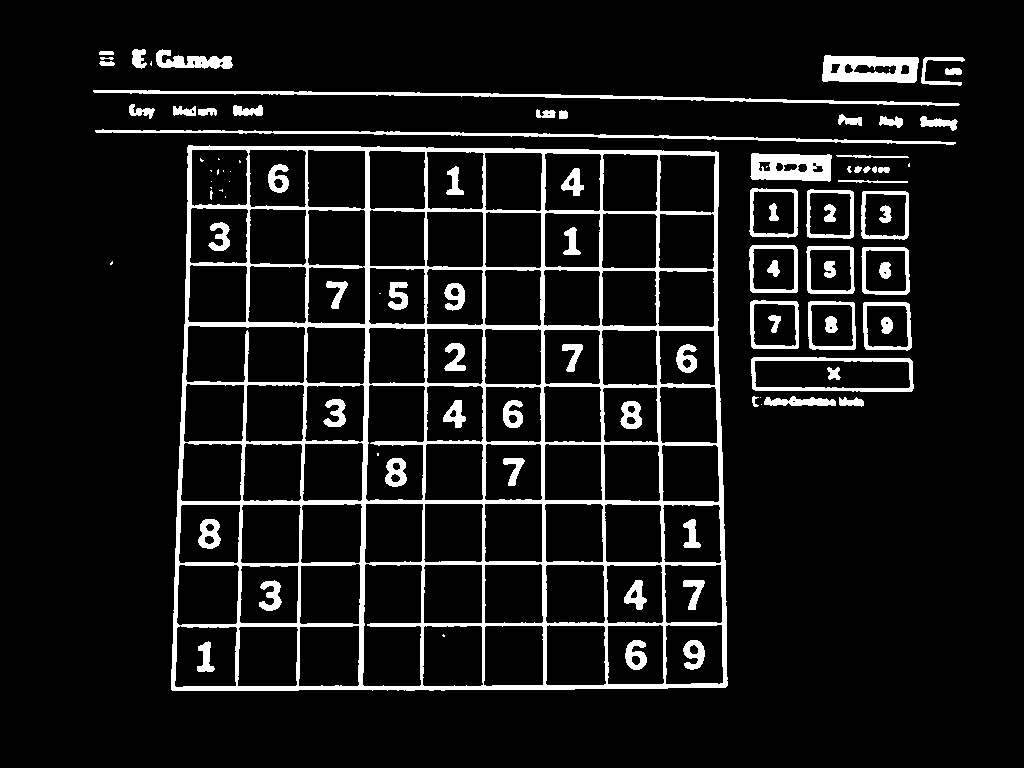

In [9]:
blackwhite = binarize(gray, AdaptiveThreshold(window_size=15, percentage=7))
blackwhite = invert_image(blackwhite)
blackwhite

## Contours

221
  0.070361 seconds (225.05 k allocations: 6.397 MiB, 89.01% compilation time)
  0.002376 seconds (56.86 k allocations: 1.322 MiB)


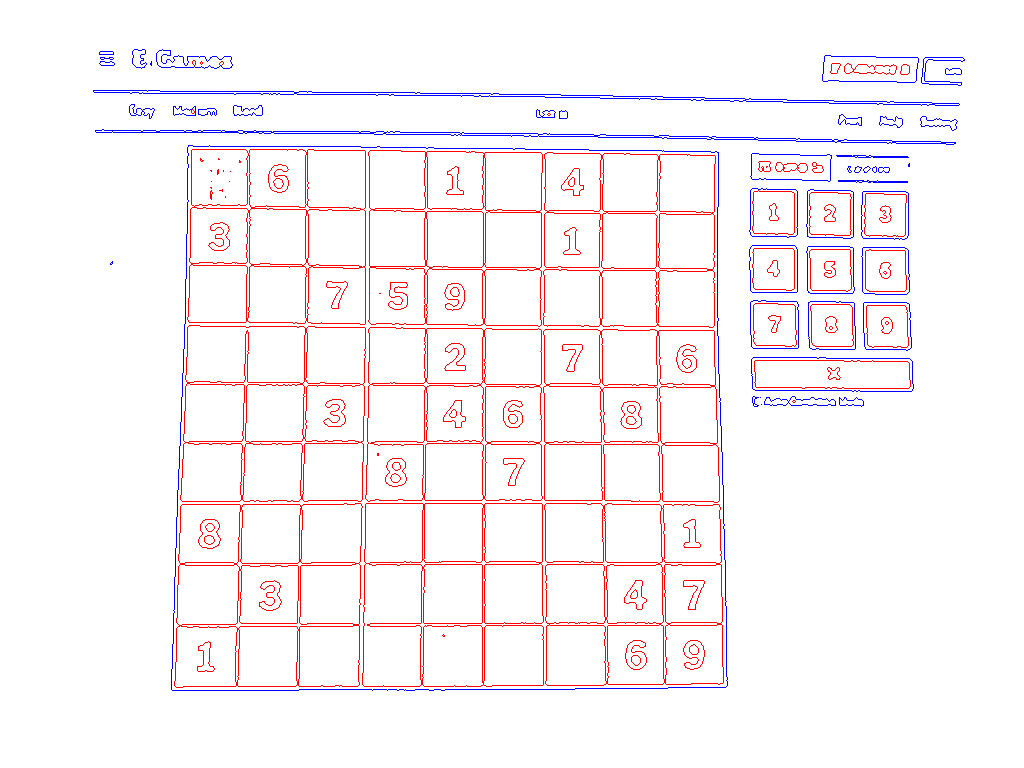

In [10]:
contours = find_contours(blackwhite)
println(length(contours))
img_contours = ones(RGB, size(image)) # copy(image)
@time draw_contours!(img_contours, RGB(1,0,0), contours)
contours = find_contours(blackwhite, external_only=true)
@time draw_contours!(img_contours, RGB(0,0,1), contours)
img_contours

  0.778594 seconds (1.57 M allocations: 86.696 MiB, 4.52% gc time, 86.19% compilation time)


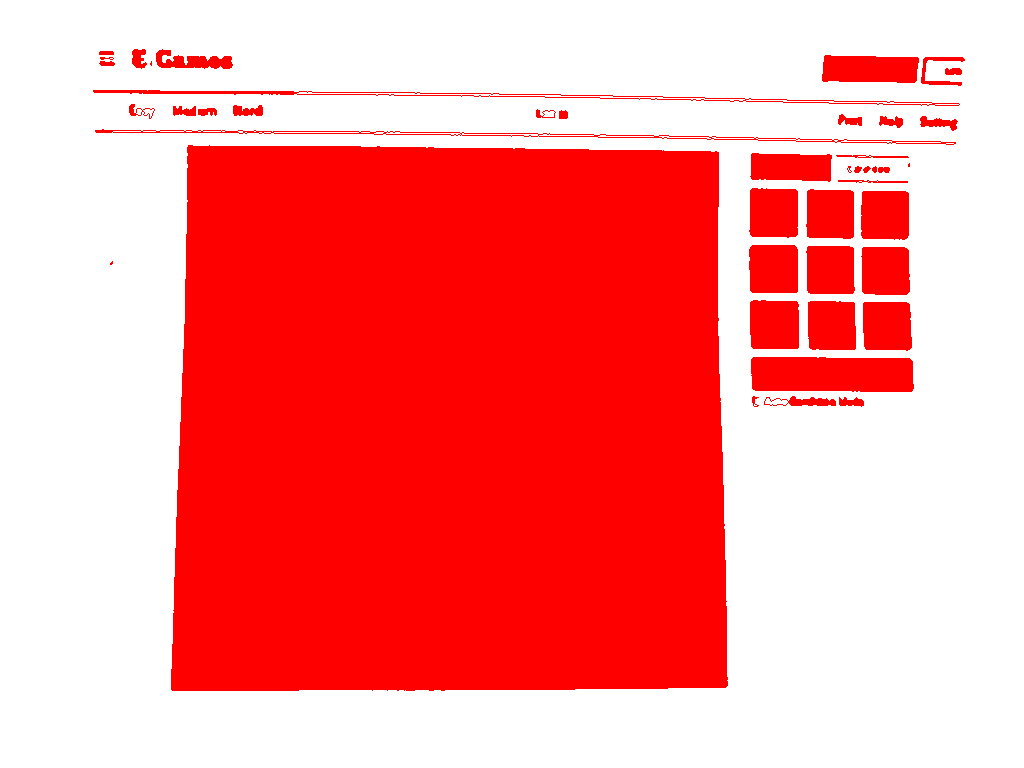

In [11]:
contours = find_contours(blackwhite, external_only=true)
img_contours = ones(RGB, size(image)) # copy(image)
@time fill_contours!(img_contours, RGB(1,0,0), contours)
img_contours

## Fit Rectangle

In [12]:
idx_max = argmax(map(calc_area_contour, contours))
max_contour = contours[idx_max]
print(length(max_contour))
rect = fit_rectangle(max_contour)
par = fit_parallelogram(max_contour)

2163

4-element Vector{CartesianIndex{2}}:
 CartesianIndex(146, 189)
 CartesianIndex(690, 172)
 CartesianIndex(688, 726)
 CartesianIndex(153, 719)

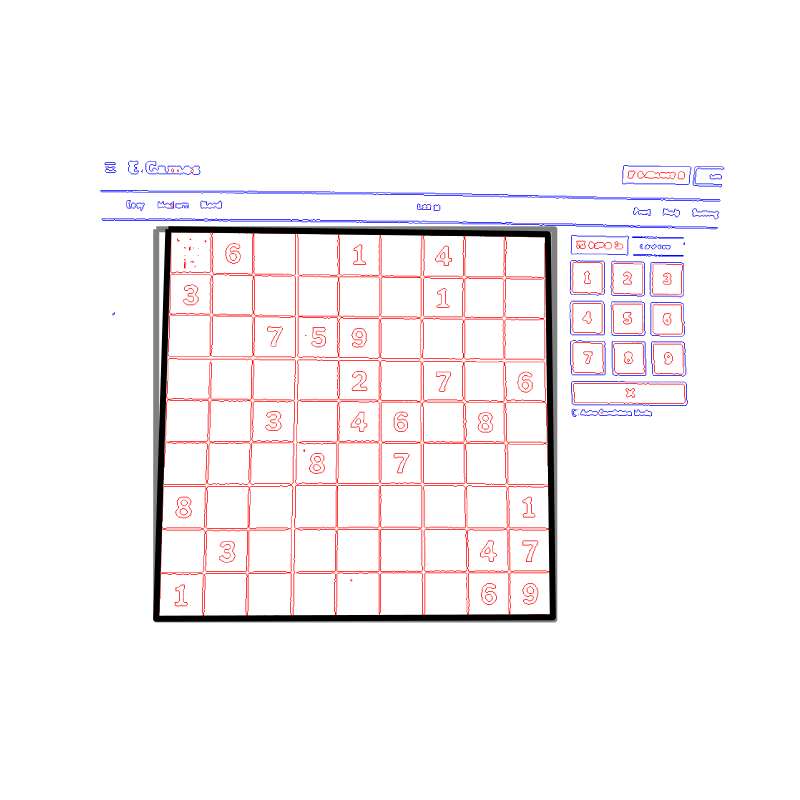

In [16]:
contours = find_contours(blackwhite)
img_contours = ones(RGB, size(image)) # copy(image)
draw_contours!(img_contours, RGB(1,0,0), contours)
contours = find_contours(blackwhite, external_only=true)
draw_contours!(img_contours, RGB(0,0,1), contours)

p = plot(img_contours, size=(800, 800))
plot!(p, 
    [point[2] for point in vcat(rect, rect[1])], [point[1] for point in vcat(rect, rect[1])], 
    linewidth=6, label="", color=:gray
    )
plot!(p, 
    [point[2] for point in vcat(par, par[1])], [point[1] for point in vcat(par, par[1])], 
    linewidth=6, label="", color=:black
    )
plot!(border=:none, ticks=nothing)

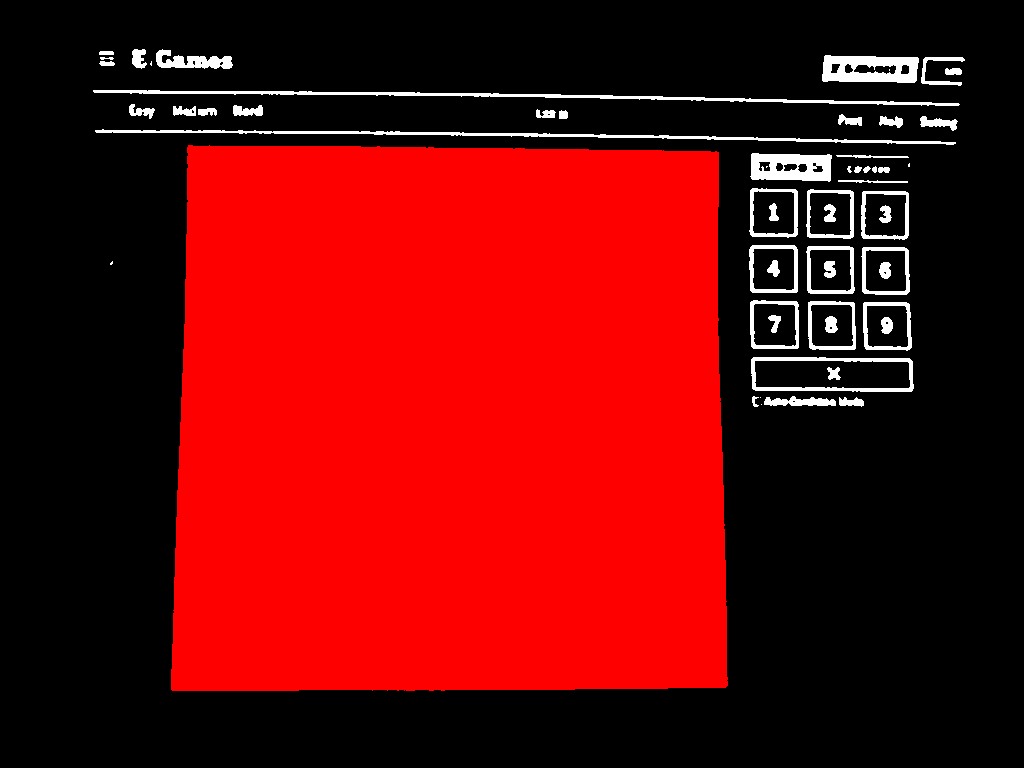

In [14]:
img_contours = RGB.(blackwhite)
fill_contour!(img_contours, RGB(1, 0, 0), max_contour)
img_contours

In [18]:
function apply_mask(image, mask)
    height, width = size(image)
    T = typeof(image).parameters[1]
    masked_image = zeros(T, size(image))
    for i in 1:height
        for j in 1:width
            masked_image[i, j] = mask[i, j] > 0 ? image[i, j] : zero(T)
        end
    end
    masked_image
end

apply_mask (generic function with 1 method)

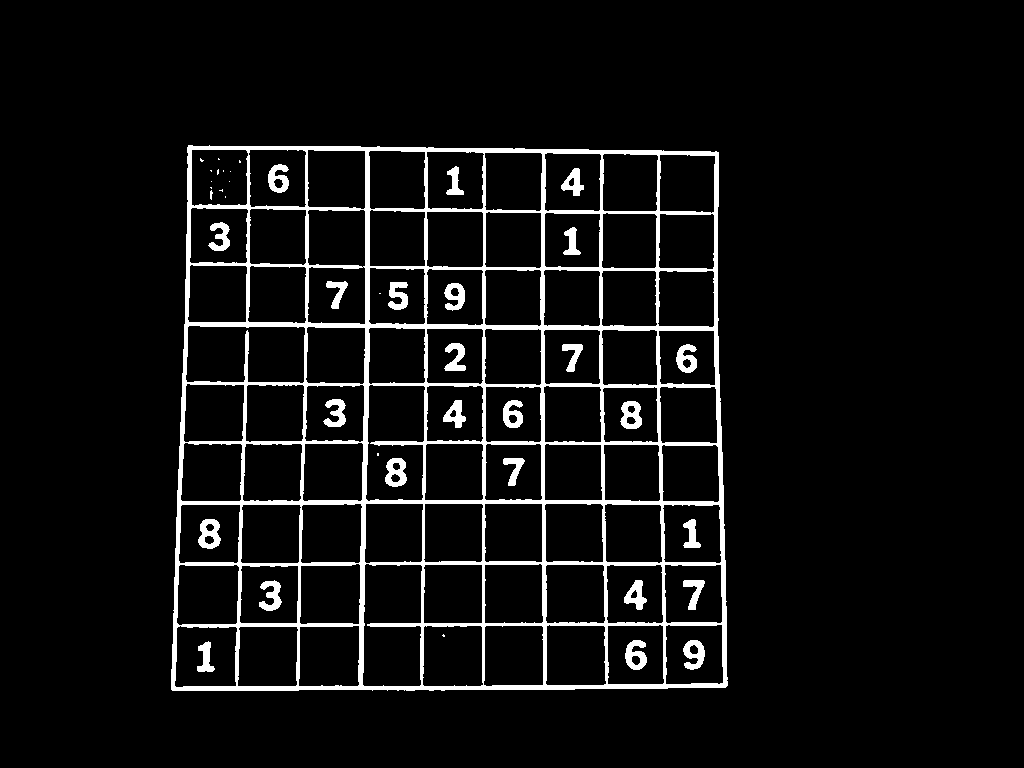

In [19]:
mask = zeros(size(image))
fill_contour!(mask, 1, max_contour)
masked_image = apply_mask(blackwhite, mask)
masked_image

## Straighten grid

In [20]:
using ImageTransformations, CoordinateTransformations
using StaticArrays

In [21]:
rect = fit_rectangle(par)
rect_offset = [CartesianIndex(point[1] - rect[1][1] + 1, point[2] - rect[1][2] + 1) for point in rect]
rect_offset

4-element Vector{CartesianIndex{2}}:
 CartesianIndex(1, 1)
 CartesianIndex(545, 1)
 CartesianIndex(545, 555)
 CartesianIndex(1, 555)

  0.174116 seconds (2.11 M allocations: 140.268 MiB, 16.67% gc time)


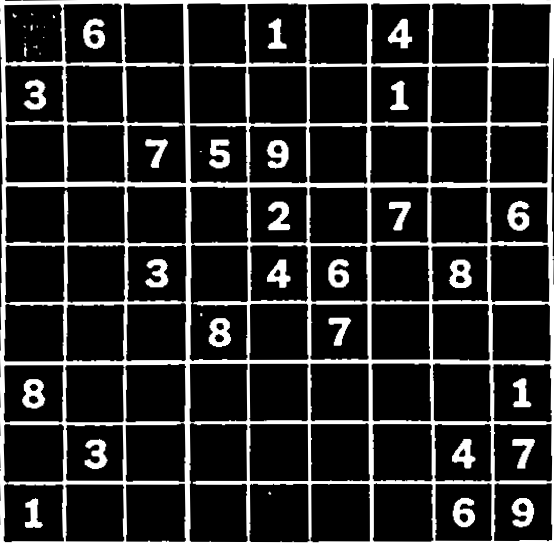

In [25]:
@time warped, invM = four_point_transform(blackwhite, par)
warped

## Test warping back

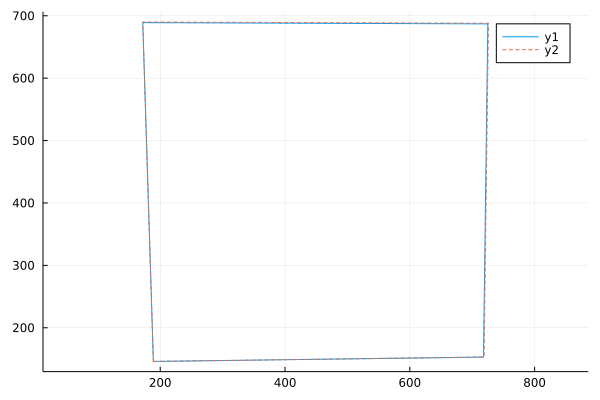

In [26]:
height, width = size(warped)
corners = [(1, 1), (1, width), (height, width), (height, 1)]
warped_corners = []
for corner in corners
    warped_corner = perspective_transform(invM)(corner)
    push!(warped_corners, warped_corner)
end
y = [point[1] for point in warped_corners]
x = [point[2] for point in warped_corners]
plot(vcat(x, x[1]), vcat(y, y[1]), aspectratio=1)

y = [point[1] for point in par]
x = [point[2] for point in par]
plot!(vcat(x, x[1]), vcat(y, y[1]), linestyle=:dash)

In [39]:
image_orig = copy(image)
height_orig, width_orig = size(image_orig)

image_warp, invM = four_point_transform(image, par)
height_warp, width_warp = size(image_warp)
M = inv(invM)

for i in 1:10
    image_orig = warp(image_warp, perspective_transform(M), (1:width_orig, 1:height_orig))
    image_warp = warp(image_orig, perspective_transform(invM), (1:height_warp, 1:width_warp))
end
image_warp